In [55]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from math import sqrt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values

import time

cudaq.set_target("nvidia")

In [56]:
# from qiskit_finance.applications.optimization import PortfolioOptimization
# from qiskit_optimization.algorithms import MinimumEigenOptimizer
# from qiskit_algorithms import QAOA
# from qiskit_algorithms.optimizers import COBYLA
# from qiskit.primitives import Sampler
# from qiskit_optimization.converters import QuadraticProgramToQubo
# from qiskit.circuit.library import QAOAAnsatz
# from qiskit_optimization.translators import to_ising
# from qiskit.result import marginal_distribution

# Preserving Mixer Hamiltonian

In [57]:
def pauli_to_int(pauli_str: str) -> int:
    value = 0
    for i, char in enumerate(pauli_str):
        if char == 'I':
            value |= (1 << (2 * i)) * 0
        elif char == 'X':
            value |= (1 << (2 * i)) * 1
        elif char == 'Y':
            value |= (1 << (2 * i)) * 2
        elif char == 'Z':
            value |= (1 << (2 * i)) * 3
    return value

def int_to_pauli(value: int, n_qubits: int) -> str:
    pauli_str = ""
    for i in range(n_qubits):
        if (value >> 2*i) % 4 == 0:
            pauli_str += 'I'
        elif (value >> 2*i) % 4 == 1:
            pauli_str += 'X'
        elif (value >> 2*i) % 4 == 2:
            pauli_str += 'Y'
        elif (value >> 2*i) % 4 == 3:
            pauli_str += 'Z'
    return pauli_str

def basis_T_to_pauli(bases: List[str], T: np.ndarray, n_qubits: int) -> Tuple[List[cudaq.pauli_word], List[float]]:
    def init_pauli(x, y):
        if x == "0" and y == "0":
            A = spin.i(0) + spin.z(0)
            # B = spin.i(0) + spin.z(0)
            B = 0
        elif x == "0" and y == "1":
            A = spin.x(0)
            B = -spin.y(0)
        elif x == "1" and y == "0":
            A = spin.x(0)
            B = spin.y(0)
        elif x == "1" and y == "1":
            A = spin.i(0) - spin.z(0)
            # B = spin.i(0) - spin.z(0)
            B = 0
        return A, B

    def transform_pauli(x, y, idx, A, B):
        if x == "0" and y == "0":
            A_, B_ = 0.5 * A * (spin.i(idx) + spin.z(idx)), 0.5 * B * (spin.i(idx) + spin.z(idx))
        elif x == "0" and y == "1":
            A_, B_ = 0.5 * (A * spin.x(idx) + B * spin.y(idx)), 0.5 * (B * spin.x(idx) - A * spin.y(idx))
        elif x == "1" and y == "0":
            A_, B_ = 0.5 * (A * spin.x(idx) - B * spin.y(idx)), 0.5 * (B * spin.x(idx) + A * spin.y(idx))
        elif x == "1" and y == "1":
            A_, B_ = 0.5 * A * (spin.i(idx) - spin.z(idx)), 0.5 * B * (spin.i(idx) - spin.z(idx))
        return A_, B_
    
    def get_pauli(X, Y):
        A, B = init_pauli(X[0], Y[0])
        for i in range(1, len(X)):
            A, B = transform_pauli(X[i], Y[i], i, A, B)
        return A, B
        
    A_all, B_all = 0, 0
    for i in range(T.shape[0]):
        for j in range(i + 1, T.shape[1]):
            A_now, B_now = get_pauli(bases[i], bases[j])
            A_all += T[i, j] * A_now
            B_all += T[i, j] * B_now
    
    ret_s, ret_c = [], []

    for i in A_all:
        s = i.get_pauli_word(n_qubits)
        c = i.evaluate_coefficient()
        if len(s) > 0 and c.real != 0:
            # ret_s.append(pauli_to_int(s))
            ret_s.append(s)
            # print(s)
            ret_c.append(c.real)
    
    return ret_s, ret_c

def reversed_str_bases_to_init_state(bases: List[str], n_qb: int) -> np.ndarray:
    assert len(bases[0]) == n_qb, f"Length of bases: {len(bases[0])} must match number of qubits: {n_qb}"

    init_state = np.zeros(2**n_qb, dtype=cudaq.complex())
    for base in bases:
        base_i = int(base[::-1], 2)
        init_state[base_i] = 1.0 / sqrt(len(bases))
    return init_state
            

!! warning: Representing Pauli words using INTEGER !!

In [58]:
print(4**30 // 10**18)

1


# HAMILTONIAN BY CUDAQ

### by random values

In [59]:
B = 100
ret = np.array([1.0, 1.25, 1.5])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)

[[1.87103079 0.4428191  1.62352066]
 [0.4428191  1.79482202 1.04871607]
 [1.62352066 1.04871607 0.47544325]]
n_max: [1 1 1]
ret_bb: [1.   1.25 1.5 ]
n_qubit: 3


In [60]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.5+0i) * I0 + (0.5+0i) * Z0 + (0+0i) + (-0.625+0i) * I1 + (0.625+0i) * Z1 + (-0.75+0i) * I2 + (0.75+0i) * Z2
[0, 1, 2]
[0.5, 0.625, 0.75]

[]
[]
[]


### by stock values

In [61]:
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

nn = 3
# B = 1500
B = 270
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
print(data_cov)
data_ret_p = data_ret_p.iloc[:nn]
# data_ret_p.loc[0, "Average_Return"] = 0.002070
# data_ret_p.loc[1, "Average_Return"] = 0.000050
# data_ret_p.loc[2, "Average_Return"] = 0.002070
print(data_ret_p)
stock_names = data_ret_p["Ticker"].tolist()
data_ret_p = data_ret_p.drop("Ticker", axis=1)

data_cov = data_cov.to_numpy()
data_ret_p = data_ret_p.to_numpy()

data_ret = data_ret_p[:, 0]
data_p = data_ret_p[:, 1]

print(data_cov.shape)
print(data_ret.round(5))
print(data_p.round(2))
print(stock_names)

       AAPL      ABBV       ABT
0  0.000772  0.000078  0.000100
1  0.000078  0.000279  0.000103
2  0.000100  0.000103  0.000256
  Ticker  Average_Return       Price
0   AAPL        0.001070  195.270004
1   ABBV        0.000832  183.259995
2    ABT        0.000706  131.300003
(3, 3)
[0.00107 0.00083 0.00071]
[195.27 183.26 131.3 ]
['AAPL', 'ABBV', 'ABT']


In [62]:
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, data_p, data_ret, data_cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb).canonicalize() * 100

n_max: [1 1 2]
ret_bb: [0.00077414 0.00056486 0.00034333 0.00068666]
n_qubit: 4


In [63]:
print("Hamiltonian:", H)
# print("H canonicalized:", H.canonicalize())
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.11845+0i) + (0.0387072+0i) * Z0 + (0.0282431+0i) * Z1 + (0.0171665+0i) * Z2 + (0.034333+0i) * Z3
[0, 1, 2, 3]
[0.03870724287719349, 0.02824307571581706, 0.017166494380170948, 0.034332988760341895]

[]
[]
[]


# QISKIT QAOA

In [64]:
# # cov[0, 2] = cov[2, 0] = 1
# print(cov)
# portfolio_qis = PortfolioOptimization(
#     expected_returns=ret,
#     covariances=cov,
#     risk_factor=0,
#     budget=1,
#     bounds=[(0, 1), (0, 1), (0, 1)]
# )
# qp = portfolio_qis.to_quadratic_program()
# converter = QuadraticProgramToQubo()
# qubo = converter.convert(qp)
# op, offset = to_ising(qubo)

In [65]:
# opp = op.to_sparse_list()
# print(opp)
# idx_1_qis = []
# coeff_1_qis = []
# idx_2_a_qis, idx_2_b_qis = [], []
# coeff_2_qis = []

# for i in range(len(opp)):
#     if len(opp[i][1]) == 1:
#         idx_1_qis.append(opp[i][1][0])
#         coeff_1_qis.append(opp[i][2].real)
#     elif len(opp[i][1]) == 2:
#         idx_2_a_qis.append(opp[i][1][0])
#         idx_2_b_qis.append(opp[i][1][1])
#         coeff_2_qis.append(opp[i][2].real)

# print(idx_1_qis)
# print(coeff_1_qis, end="\n\n")
# print(idx_2_a_qis)
# print(idx_2_b_qis)
# print(coeff_2_qis)

In [66]:
# qaoa_ansatz = QAOAAnsatz(op, reps=2)
# decomposed = qaoa_ansatz.decompose(reps=2)
# decomposed.draw(output='text')

In [67]:
# qaoa = QAOA(
#     optimizer=COBYLA(maxiter=1000),
#     reps=2,
#     sampler=Sampler()
# )

# meo = MinimumEigenOptimizer(qaoa)

# # result = meo.solve(qubo)

In [68]:
# qaoa_result = qaoa.compute_minimum_eigenvalue(operator=op)
# print("Optimized parameters:", qaoa_result.optimal_point)

In [69]:
# counts = qaoa_result.eigenstate
# counts = np.array(list(counts.values()))

In [70]:
# plt.figure(figsize=(10, 5))
# # plt.bar(range(2**qubit_count), list(result.values()))
# plt.bar(range(2**op.num_qubits), counts)
# # plt.xlabel('Cut')
# plt.ylabel('Frequency')
# plt.title('Distribution')
# # plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.show()

# Dedug Circuit

In [71]:
c = np.array([0.+0j, 0.577350269, 0.577350269, 0., 0., 0., 0., 0., 0.577350269, 0., 0., 0., 0., 0., 0., 0.], dtype=cudaq.complex())
@cudaq.kernel
def kk(cc: List[complex]):
    # a = cudaq.qvector([0.+0j, 0.577350269, 0.577350269, 0., 0., 0., 0., 0., 0.577350269, 0., 0., 0., 0., 0., 0., 0.])
    a = cudaq.qvector(cc)
    # a = cudaq.qvector([0.+0j, 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

    # h(a)
    # exp_pauli(3.14 / 4, a, "IXIX")
    # exp_pauli(3.14 / 4, a, "IYIY")
    
result = cudaq.sample(kk, c, shots_count=int(1e5))
print(result)
print(cudaq.draw(kk, c))

{ 0001:33185 0100:33364 1000:33451 }




# CUDA QAOA

In [72]:
@cudaq.kernel
def kernel_qaoa_ham(qubit_count: int, layer_count: int, thetas: List[float], idx_1: List[int], coeff_1: List[float], idx_2_a: List[int], idx_2_b: List[int], coeff_2: List[float], mixer_str: List[cudaq.pauli_word], mixer_coeff: List[float]):
    # qreg = cudaq.qvector(qubit_count)
    # h(qreg)

    # qreg = cudaq.qvector([0.+0j, 0.577350269, 0.577350269, 0., 0.577350269, 0., 0., 0.])
    qreg = cudaq.qvector([0.+0j, 0.577350269, 0.577350269, 0., 0., 0., 0., 0., 0.577350269, 0., 0., 0., 0., 0., 0., 0.])
    
    for i in range(layer_count):

        for j in range(len(idx_1)):
            rz(2 * coeff_1[j] * thetas[i], qreg[idx_1[j]])
        
        for j in range(len(idx_2_a)):
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])
            rz(2 * coeff_2[j] * thetas[i], qreg[idx_2_b[j]])
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])

        # exp_pauli(0.5, qreg, "XXI")
        for j in range(len(mixer_str)):
            exp_pauli(mixer_coeff[j] * thetas[layer_count + i], qreg, mixer_str[j])

        # for j in range(qubit_count):
        #     rx(2.0 * thetas[layer_count + i], qreg[j])


In [73]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [74]:
print(H)
print(n_qubit)

(-0.11845+0i) + (0.0387072+0i) * Z0 + (0.0282431+0i) * Z1 + (0.0171665+0i) * Z2 + (0.034333+0i) * Z3
4


In [75]:
# bases = ["0001", "0010"]
# T = np.array([[0, 1], [1, 0]])
# mixer_s, mixer_c, A_all = basis_T_to_pauli(bases, T, len(bases[0]))
# print(f"{mixer_s}\n{mixer_c}")

# print(A_all.to_matrix())

# # AA_all = A_all.copy()
# AA_all = 0.25 * spin.x(0) * spin.x(2) + 0.25 * spin.x(0) * spin.z(1) * spin.x(2) \
#        + 0.25 * spin.y(0) * spin.y(2) + 0.25 * spin.y(0) * spin.z(1) * spin.y(2)
# print(AA_all.to_matrix())

In [77]:
# bases = ["100", "010", "001"]
# T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

bases = ["1000", "0100", "0001"]
T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
# T = np.array([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
# T = np.array(
#     [[0, 1, 0, 1],
#      [1, 0, 1, 0],
#      [0, 1, 0, 1],
#      [1, 0, 1, 0]]
# )

mixer_s, mixer_c = basis_T_to_pauli(bases, T, n_qubit)

# ss_i = [int_to_pauli(s, n_qubit) for s in mixer_s]
# print(f"{mixer_s}\n{ss_i}\n{mixer_c}")

print(f"{mixer_s}\n{mixer_c}")
init_bases = reversed_str_bases_to_init_state(bases, n_qubit)
print("init_bases:", abs(init_bases))

['XXII', 'XXIZ', 'XXZI', 'XXZZ', 'YYII', 'YYIZ', 'YYZI', 'YYZZ', 'XIIX', 'XIZX', 'XZIX', 'XZZX', 'YIIY', 'YIZY', 'YZIY', 'YZZY', 'IXIX', 'IXZX', 'ZXIX', 'ZXZX', 'IYIY', 'IYZY', 'ZYIY', 'ZYZY']
[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
init_bases: [0.         0.57735026 0.57735026 0.         0.         0.
 0.         0.         0.57735026 0.         0.         0.
 0.         0.         0.         0.        ]


In [48]:
print(cudaq.draw(kernel_qaoa_ham, n_qubit, 1, [0.5]*4, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c)) 

     ╭─────────────╮╭───╮                        ╭───╮╭───╮          »
q0 : ┤ rz(0.03871) ├┤ h ├──●──────────────────●──┤ h ├┤ h ├──●───────»
     ├─────────────┤├───┤╭─┴─╮╭────────────╮╭─┴─╮├───┤├───┤╭─┴─╮     »
q1 : ┤ rz(0.02824) ├┤ h ├┤ x ├┤ rz(-0.125) ├┤ x ├┤ h ├┤ h ├┤ x ├──●──»
     ├─────────────┤╰───╯╰───╯╰────────────╯╰───╯╰───╯╰───╯╰───╯  │  »
q2 : ┤ rz(0.01717) ├──────────────────────────────────────────────┼──»
     ├─────────────┤                                            ╭─┴─╮»
q3 : ┤ rz(0.03433) ├────────────────────────────────────────────┤ x ├»
     ╰─────────────╯                                            ╰───╯»

################################################################################

                        ╭───╮╭───╮                                  ╭───╮╭───╮»
─────────────────────●──┤ h ├┤ h ├──●────────────────────────────●──┤ h ├┤ h ├»
                   ╭─┴─╮├───┤├───┤╭─┴─╮                        ╭─┴─╮├───┤├───┤»
────────────────●──┤ x ├┤ h ├┤ h ├┤ x 

# Ansatz Architecture

In [ ]:
idx = 3
layer_count = 5

parameter_count = layer_count * 2

optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()
optimizer5 = cudaq.optimizers.GradientDescent()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam", "GradientDescent"]
optimizer_name = optimizer_names[idx]
FIND_GRAD = True if optimizer.requires_gradients() else False

optimizer.max_iterations = 1000


optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [0.2186044933749255, -0.32233918533433326, -0.09730302699043475, 0.3550828804631453, 0.3568555242693041, -0.35765435674092566, 0.0765017838233843, 0.3919978599664339, 0.3202192015450225, -0.23612810777567947]


In [50]:
print(optimizer.episodes)

None


# Optimize

In [51]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_ham, H, n_qubit, layer_count, parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [52]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO_mixer"):
    os.makedirs("./output_PO_mixer")
np.save(f"./output_PO_mixer/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = -0.0769461685499037
optimal_parameters = [0.21553797847265513, -0.18409713115278828, 0.09346987515194354, 0.4208061573509488, 0.16140216325550819, -0.7444503909840715, -0.2576435149982654, 0.7713185037009933, 0.2777106902531011, -0.578476637906113]
Time taken =  7.109633684158325


In [53]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
1000 970327 0.970327
|q0>|q1>|q2>...


In [54]:
state = cudaq.get_state(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c)
print(state)

for i in range(len(state)):
    bb = bin(i)[2:].zfill(n_qubit)
    print(bb, abs(state[i])**2)

print(len(state))

SV: [(0,0), (0.627516,-0.759421), (0.0669676,-0.0817427), (0,0), (0,0), (0,0), (0,0), (0,0), (-0.135266,-0.00601387), (0,0), (0,0), (4.95172e-09,-6.91649e-09), (0,0), (0,0), (0,0), (0,0)]

0000 0.0
0001 0.01833317592990391
0010 0.0
0011 0.0
0100 0.01116652875151397
0101 0.0
0110 0.0
0111 0.0
1000 0.970496941652712
1001 0.0
1010 0.0
1011 0.0
1100 0.0
1101 7.235739367056657e-17
1110 0.0
1111 0.0
16


In [55]:
assert False

AssertionError: 

In [56]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

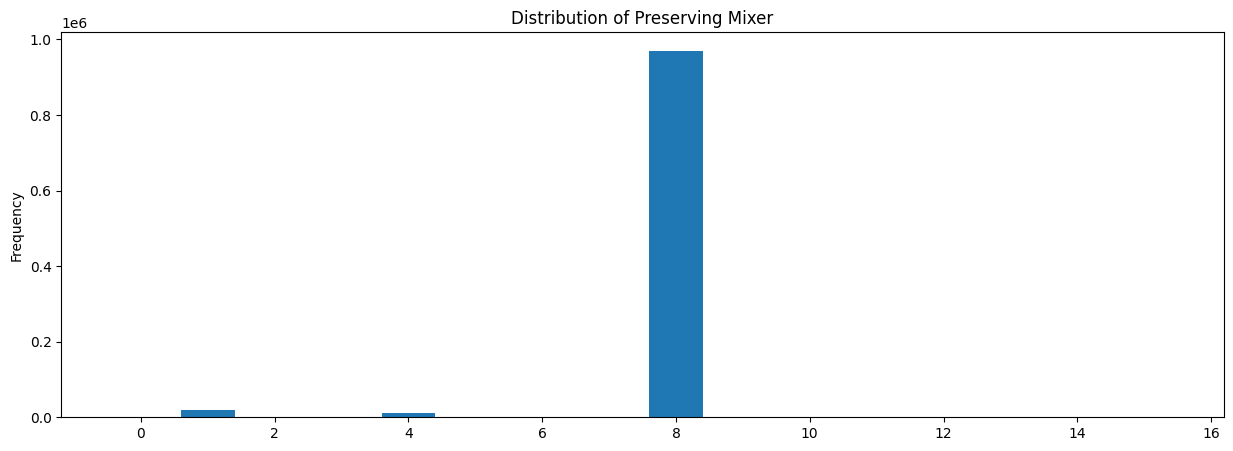

In [57]:
# plt.figure(figsize=(100, 15))
plt.figure(figsize=(15, 5))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution of Preserving Mixer')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
plt.show()

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


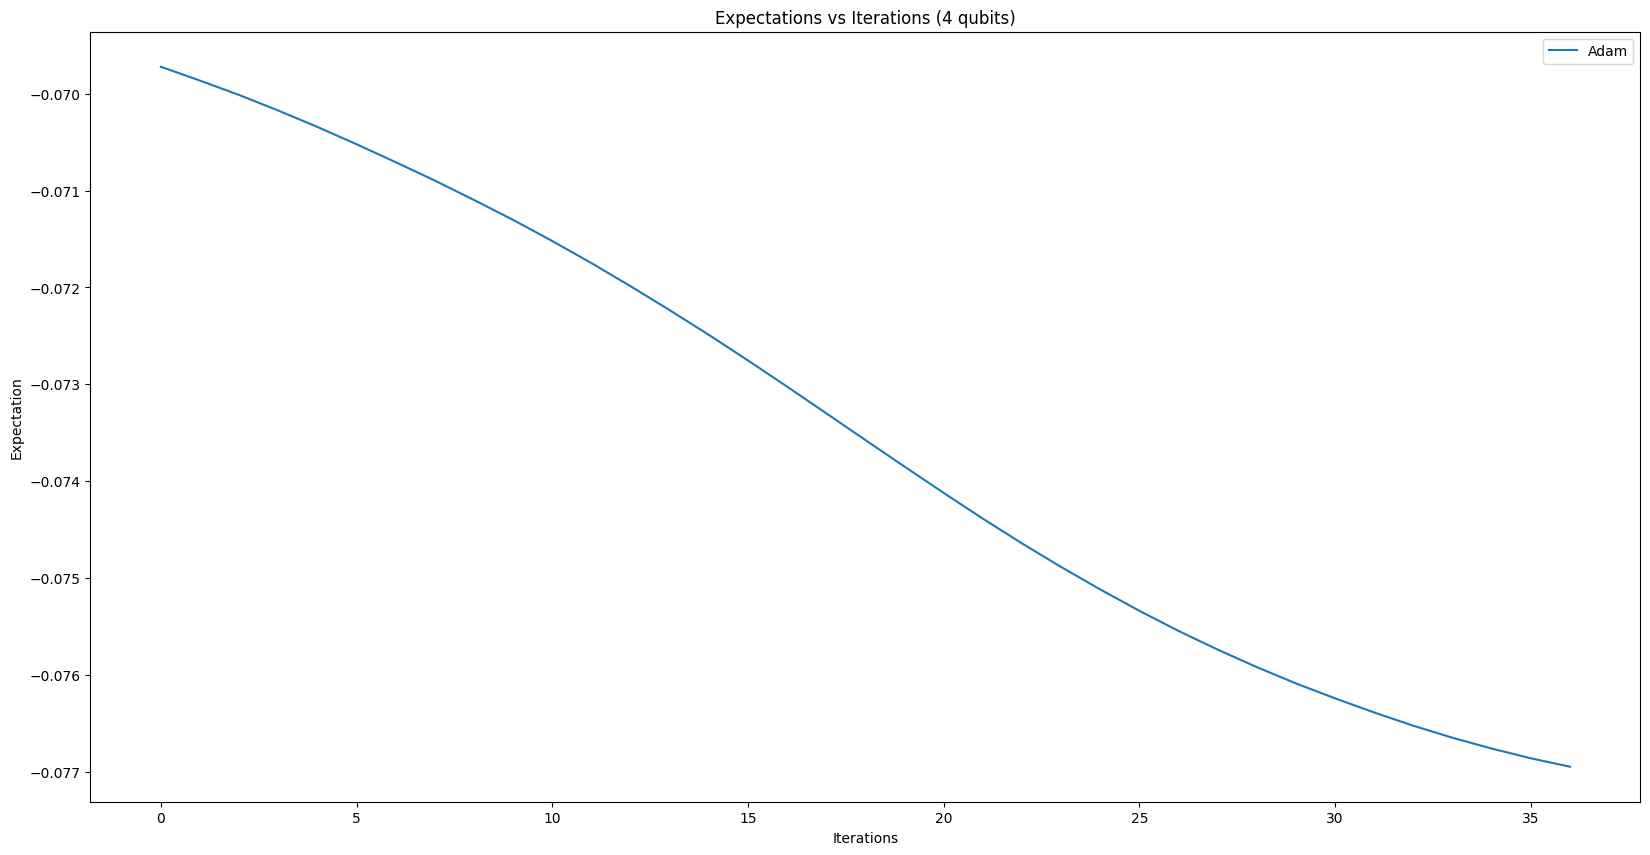

In [58]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()